In [22]:
from doppler_imaging import *
import numpy as np
import paths
import os

##############################################################################
####################    Configs     ##########################################
##############################################################################

from config_sim import *

band = "K"

nlat, nlon = 10, 20
use_eqarea = True
target = "W1049A"
noisetype = "random"
contrast = 0.5
roll = 0

tobs = 5
period = 12
period_true = period

#modelspec = "t1400g1000f8"
goodchips_sim[instru][target][band] = [4]
savedir = f"sim_period/{period_true}"

#################### Automatic ####################################

if True:
    if not os.path.exists(paths.figures / savedir):
        os.makedirs(paths.figures / savedir)

    cut = nk - 70
    # Auto consistent options
    if map_type == "eqarea":
        use_eqarea = True

    nobs = nobss[target]

    # set chips to include
    goodchips = goodchips_sim[instru][target][band]
    if use_toy_spec:
        goodchips = [4]
    nchip = len(goodchips)

    # set model files to use
    if "t1" in modelspec:
        if instru == "CRIRES": #TODO: put CRIRES data here
            model_datafiles = {"W1049B": 'fainterspectral-fits_6.pickle', "W1049A":'brighterspectral-fits_6.pickle'}
            model_datafile = model_datafiles[target]
        else:
            model_datafile = paths.data / f'{instru}_{target}_{band}_{modelspec}.pickle'
        pmod = f'linbroad_{modelspec}'
        rv = rvs[target]
        if use_toy_spec:
            print("Using toy spectrum...")
            pmod = f'toy_{modelspec}'
            rv = 0

    elif "lte" in modelspec: #TODO: shall I just delete this option
        if instru == "CRIRES":
            model_datafiles = {"W1049B": 'fainterspectral-fits_6.pickle', "W1049A":'brighterspectral-fits_6.pickle'}
            model_datafile = model_datafiles[target]
        else:
            model_datafile = paths.data / f'{instru}_{target}_{band}_{modelspec}.pickle'
        pmod = 'linbroad_lte015'
        rv = rvs[target]

    line_file = paths.data / f'linelists/{pmod}_edited.clineslsd'
    cont_file = paths.data / f'linelists/{pmod}C.fits'

    # set solver parameters
    inc = incs[target]
    vsini = vsinis[target]
    veq = vsini / np.sin(inc * np.pi / 180)

    # set time and period parameters
    timestamp = np.linspace(0, tobs, nobs)  # observed time points in hours
    phases = timestamp * 2 * np.pi / period # 0 ~ 2*pi in rad     # guessed
    theta = 360.0 * timestamp / period      # 0 ~ 360 in degree   # guessed 
    theta_true = 360.0 * timestamp / period_true # sim using true period, retrieve using guessed period

    assert nobs == len(theta)

    kwargs_sim = dict(
        ydeg=ydeg_sim,
        udeg=udeg,
        nc=nc,
        veq=veq,
        inc=inc,
        nt=nobs,
        vsini_max=vsini_max,
        u1=u1,
        theta=theta_true)

    kwargs_run = kwargs_sim.copy()
    kwargs_run['ydeg'] = ydeg
    kwargs_run['theta'] = theta_true

    kwargs_IC14 = dict(
        phases=phases, 
        inc=inc, 
        vsini=vsini, 
        LLD=LLD, 
        eqarea=use_eqarea, 
        nlat=nlat, 
        nlon=nlon,
        alpha=alpha,
        ftol=ftol
    )

    kwargs_fig = dict(
        goodchips=goodchips,
        noisetype=noisetype,
        contrast=contrast,
        savedir=savedir
    )


assert simulation_on == True
print(f"Using real observation {model_datafile}")

Using real observation /Users/xqchen/workspace/igrins_doppler_imaging/src/data/IGRINS_W1049A_K_t1500g1000f8.pickle


nobs: 14, nchip: 1, npix: 1848
mean_spectrum: (1, 1848)
template: (14, 1, 1848)
observed: (14, 1, 1648)
wav: (1, 1648), wav0: (1, 1848)
Running spot brightness 50.0% of surrounding


Pre-computing some matrices... Done.
Compiling `P`... Done.
Compiling `set_vector`... Done.
Compiling `enforce_shape`... Done.
Compiling `get_flux_from_dotconv`... Done.
Pre-computing some matrices... Done.
Compiling `P`... Done.
Compiling `render`... Done.


0.5
nan nan


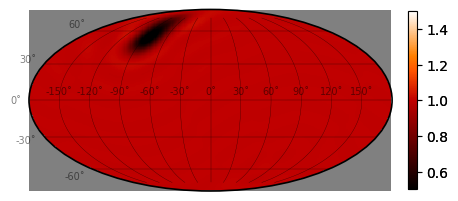

In [23]:
# Load data from fit pickle
mean_spectrum, template, observed, residual, error, wav_nm, wav0_nm = load_data(model_datafile, instru, nobs, goodchips)

# Make mock observed spectra
observed, image = spectra_from_sim(modelmap, contrast, roll, smoothing, mean_spectrum, wav_nm, wav0_nm, error, residual, 
                            noisetype, kwargs_sim, savedir, r_deg=20, lat_deg=60, lon_deg=-85, plot_ts=False, colorbar=False)

IGRINS
dbeta 6.709638190210383e-06
chip 4
chip: 4 obs: 0 offset: 0
modkerns shifted to center.
chip: 4 obs: 1 offset: 0
chip: 4 obs: 2 offset: 0
chip: 4 obs: 3 offset: 0
chip: 4 obs: 4 offset: 0
chip: 4 obs: 5 offset: 0
chip: 4 obs: 6 offset: 0
chip: 4 obs: 7 offset: 0
chip: 4 obs: 8 offset: 0
chip: 4 obs: 9 offset: 0
chip: 4 obs: 10 offset: 0
chip: 4 obs: 11 offset: 0
chip: 4 obs: 12 offset: 0
chip: 4 obs: 13 offset: 0
*** Using solver IC14new ***
Created equa-area grid of 216 cells, in 12 latitude grids with [ 6 12 17 21 25 27 27 25 21 17 12  6] lontitude cells.
  ITER       METRIC         FACTOR             DMETRIC
      1   -26703.414941   1.50000e+00   -9.847e+00
      2   -26714.292667   2.25000e+00   -1.088e+01
      3   -26724.422707   3.37500e+00   -1.013e+01
      4   -26731.577386   5.06250e+00   -7.155e+00
      5   -26734.864467   7.59375e+00   -3.287e+00
      6   -26736.011312   1.13906e+01   -1.147e+00
      7   -26736.993787   1.70859e+01   -9.825e-01
      8   -26738.

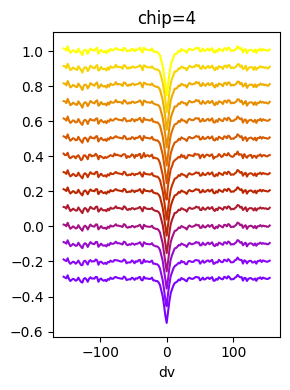

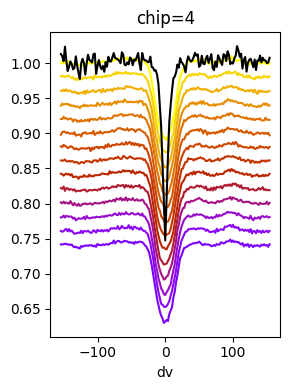

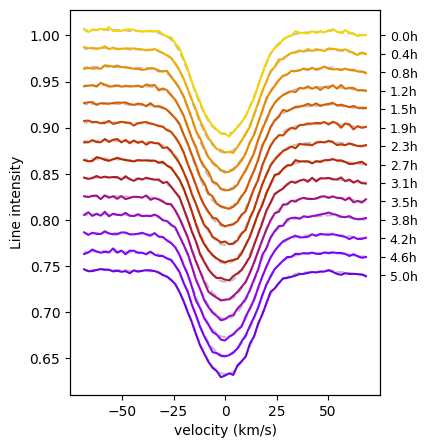

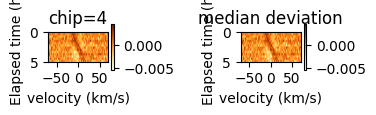

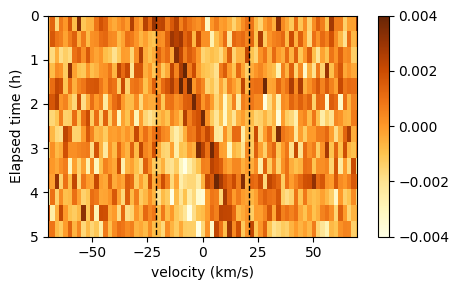

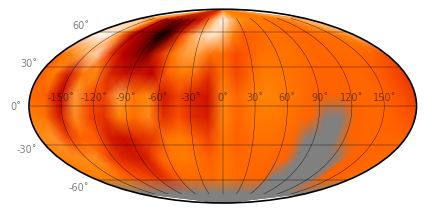

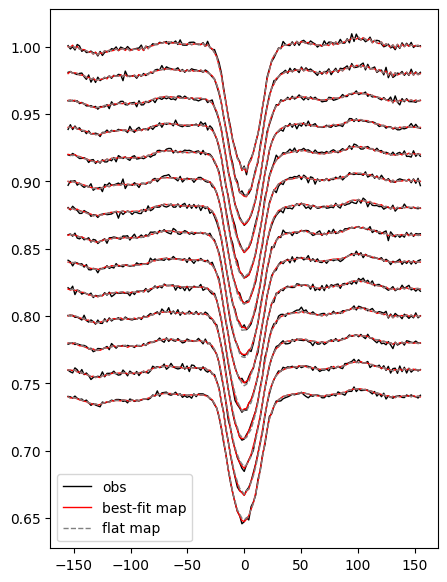

In [24]:
intrinsic_profiles, obskerns_norm = make_LSD_profile(instru, template, observed, wav_nm, goodchips, pmod, line_file, cont_file, nk, vsini, rv, 
                                                        period, timestamp, savedir, cut=cut)

bestparamgrid_r, res = solve_IC14new(intrinsic_profiles, obskerns_norm, kwargs_IC14, kwargs_fig, annotate=False, colorbar=False)

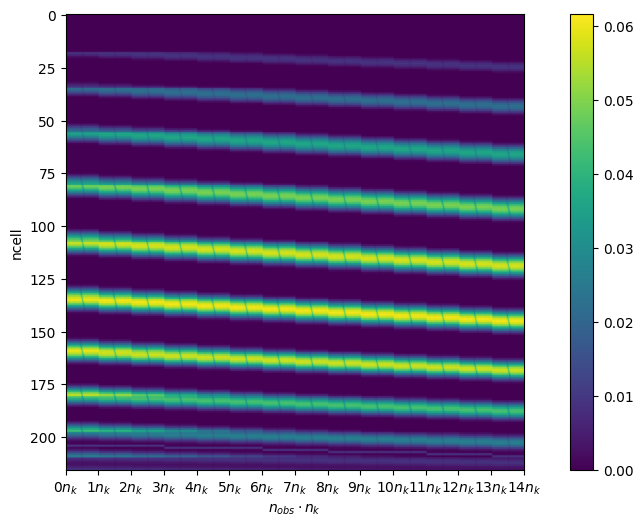

In [25]:
plt.figure(figsize=(12,12))
Rmatrix = res['Rmatrix']
plt.imshow(res['Rmatrix'], aspect=10)
plt.xlabel("$n_{obs} \cdot n_k$")
plt.ylabel("ncell")
plt.xticks(np.arange(0, nk*nobs+1, nk), [f"{n}$ n_k$" for n in np.arange(0, nobs+1)])
plt.colorbar()
plt.subplots_adjust(bottom=0.5)

In [26]:
ncell = res['mmap'].ncell
dv = res['dv']
flineSpline = res['flineSpline']

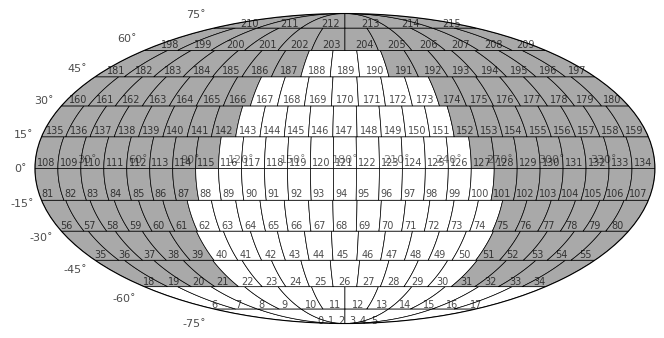

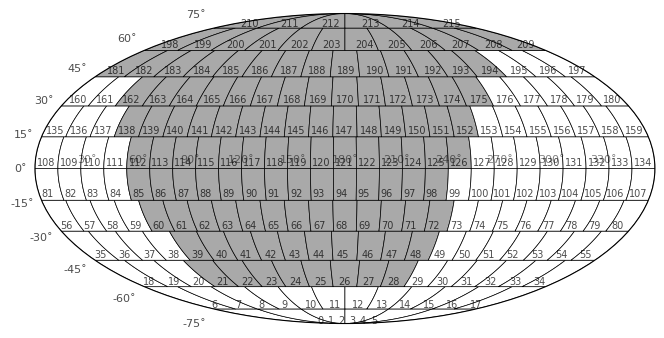

In [27]:
inc_ = (90 - inc) * np.pi / 180
for rot in [phases[0], phases[-1]]:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="mollweide")
    ax.grid(False)
    this_map = ELL_map.map(nlat=nlat, nlon=nlon, type='eqarea', inc=inc_, deltaphi=-rot)
    this_doppler = 1. + vsini*this_map.visible_rvcorners.mean(1)/const.c/np.cos(inc_) # mean rv of each cell in m/s
    good = (this_map.projected_area>0) #* np.isfinite(this_doppler)
    for k in range(this_map.ncell):
        lats = this_map.corners_latlon[k][0]
        lons = this_map.corners_latlon[k][1]

        y = np.array([lats[0], lats[1], lats[3], lats[2]]) - np.pi/2
        x = np.array([lons[0], lons[1], lons[3], lons[2]]) - np.pi
        # Plot the polygon
        if good[k]:
            poly = plt.Polygon(np.column_stack((x, y)), facecolor='darkgray', edgecolor='black', linewidth=0.5)
        else:
            poly = plt.Polygon(np.column_stack((x, y)), facecolor='white', edgecolor='black', linewidth=0.5)
        ax.add_patch(poly)
        ax.text(x.mean()-0.1, y.mean()-0.1, f"{k}", size=7, alpha=0.7)
        #ax.text(x.mean()-0.1, y.mean()-0.07, f"a:{map_obj.projected_area[k]:.3f}", size=5)

    # Set plot parameters
    ax.set_xticklabels([f'{deg}˚' for deg in [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]], fontsize=8, alpha=0.5)
    #ax.set_xticks([])
    ax.set_yticks(np.arange(-75, 90, 15)*np.pi/180, [f'{deg}˚' for deg in np.arange(-75, 90, 15)], fontsize=8, alpha=0.7)

In [8]:
bestparamgrid = res['bestparamgrid'].copy()

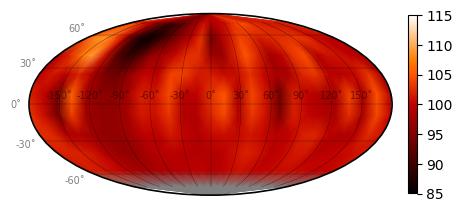

In [9]:
vmin, vmax= 85, 115
cmap = plt.cm.gist_heat
cmap.set_bad('gray', 1)
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111, projection='mollweide')
lon = np.linspace(-np.pi, np.pi, bestparamgrid_r.shape[1])
lat = np.linspace(-np.pi/2., np.pi/2., bestparamgrid_r.shape[0])
Lon,Lat = np.meshgrid(lon,lat)
im = ax.pcolormesh(Lon, Lat, bestparamgrid_r, cmap=cmap, shading='gouraud', vmin=vmin, vmax=vmax)
#ax.axhspan(-np.pi/2, -58.4/180*np.pi, color='gray', alpha=0.3)
#contour = ax.contour(Lon, Lat, gaussian_filter(bestparamgrid, sigma), clevel, colors='white', linewidths=0.5)
fig.colorbar(im, fraction=0.023, pad=0.04)
yticks = np.linspace(-np.pi/2, np.pi/2, 7)[1:-1]
xticks = np.linspace(-np.pi, np.pi, 13)[1:-1]
ax.set_yticks(yticks, labels=[f'{deg:.0f}˚' for deg in yticks*180/np.pi], fontsize=7, alpha=0.5)
ax.set_xticks(xticks, labels=[f'{deg:.0f}˚' for deg in xticks*180/np.pi], fontsize=7, alpha=0.5)
ax.grid('major', color='k', linewidth=0.25, alpha=0.7)
for item in ax.spines.values():
    item.set_linewidth(1.2)
fig.savefig(paths.figures / savedir / f"bestparamgrid_r.png", dpi=300, bbox_inches='tight')

In [10]:
image

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

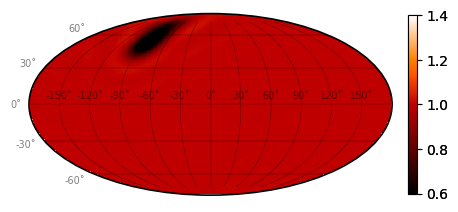

In [20]:
fig = plt.figure(figsize=(5,3))
ax2 = fig.add_subplot(111)
im = ax2.imshow(image, cmap="gist_heat", norm=Normalize(vmax=1.4, vmin=0.6), aspect=0.5, origin="lower", interpolation="nearest")
ax2.axis("off")
fig.colorbar(im, ax=ax2, fraction=0.023, pad=0.045)
ax = fig.add_subplot(111, projection='mollweide')
ax.patch.set_alpha(0)
yticks = np.linspace(-np.pi/2, np.pi/2, 7)[1:-1]
xticks = np.linspace(-np.pi, np.pi, 13)[1:-1]
ax.set_yticks(yticks, labels=[f'{deg:.0f}˚' for deg in yticks*180/np.pi], fontsize=7, alpha=0.5)
ax.set_xticks(xticks, labels=[f'{deg:.0f}˚' for deg in xticks*180/np.pi], fontsize=7, alpha=0.5)
fig.colorbar(im, ax=ax, fraction=0.023, pad=0.04, alpha=0)
ax.grid('major', color='k', linewidth=0.25, alpha=0.7)
for item in ax.spines.values():
    item.set_linewidth(1.2)

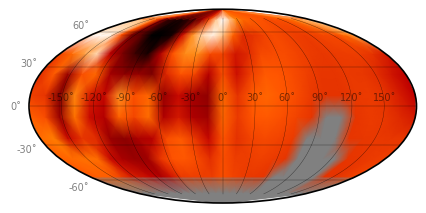

In [28]:
vmin, vmax= 85, 110
cmap = plt.cm.gist_heat
cmap.set_bad('gray', 1)
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111, projection='mollweide')
lon = np.linspace(-np.pi, np.pi, bestparamgrid.shape[1])
lat = np.linspace(-np.pi/2., np.pi/2., bestparamgrid.shape[0])
Lon,Lat = np.meshgrid(lon,lat)
im = ax.pcolormesh(Lon, Lat, bestparamgrid_r, cmap=cmap, shading='gouraud', vmin=vmin, vmax=vmax)

ax.axhspan(-np.pi/2, -58/180*np.pi, color='gray', alpha=0.3)
#contour = ax.contour(Lon, Lat, gaussian_filter(bestparamgrid, sigma), clevel, colors='white', linewidths=0.5)
#fig.colorbar(im)
yticks = np.linspace(-np.pi/2, np.pi/2, 7)[1:-1]
xticks = np.linspace(-np.pi, np.pi, 13)[1:-1]
ax.set_yticks(yticks, labels=[f'{deg:.0f}˚' for deg in yticks*180/np.pi], fontsize=7, alpha=0.5)
ax.set_xticks(xticks, labels=[f'{deg:.0f}˚' for deg in xticks*180/np.pi], fontsize=7, alpha=0.5)
ax.grid('major', color='k', linewidth=0.25, alpha=0.7)
for item in ax.spines.values():
    item.set_linewidth(1.2)